# CRC contest - 2022

In [1]:
import os
import sys
import pickle
import openslide
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import openslide.deepzoom as dz
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
ROOTDIR_SRC = "/space/ponzio/teaching-MLinAPP/src"  # icaro
# ROOTDIR_SRC = "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP/src"  colab
ROOTDIR_OUTPUT = "/space/ponzio/teaching-MLinAPP/data/contest"  # icaro
# ROOTDIR_OUTPUT = "/content/models"  # colab
DIR_DATASET = "/space/ponzio/teaching-MLinAPP/data/patch_dataset_noisy"
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)

from resnet import ResNet
from wsi_utils import DatasetManager
from sklearn import model_selection
from wsi_utils import get_heatmap
from utils import seaborn_cm

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'

Mount drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Import code from repository

In [3]:
# !rm -r "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"
# !git clone https://github.com/frpnz/teaching-MLinAPP.git "/content/drive/MyDrive/Teaching&Thesis/Teaching_dataset/teaching-MLinAPP"

# Clone dataset repository and load data

In [4]:
!rm -rf {DIR_DATASET}
try:
    os.makedirs(DIR_DATASET)
except FileExistsError:
    print("{} exists.".format(DIR_DATASET))
!git clone https://github.com/frpnz/dataset-BIOSTEC2018-noisy.git {DIR_DATASET}
import zipfile
import numpy as np
from PIL import Image
filepath = os.path.join(DIR_DATASET, "crc_3_noisy.zip")
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(DIR_DATASET)
X_test_noisy = np.load(f"{DIR_DATASET}/crc_3_noisy/X_test.npy")
Y_test_noisy = np.load(f"{DIR_DATASET}/crc_3_noisy/Y_test.npy")
X_train_noisy = np.load(f"{DIR_DATASET}/crc_3_noisy/X_train.npy")
Y_train_noisy = np.load(f"{DIR_DATASET}/crc_3_noisy/Y_train.npy")
x_mean_train = np.load(f"{DIR_DATASET}/crc_3_noisy/mean_x_train.npy")

# Undo preprocessing to plot images
X_train_noisy = X_train_noisy*255 + x_mean_train
X_train_noisy = X_train_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_train_noisy))
np.random.shuffle(indexes)
X_train_noisy = X_train_noisy[indexes]
Y_train_noisy = Y_train_noisy[indexes]
# Undo preprocessing to plot images
X_test_noisy = X_test_noisy*255 + x_mean_train
X_test_noisy = X_test_noisy.astype(np.uint8)
# Shuffle data
indexes = np.arange(len(X_test_noisy))
np.random.shuffle(indexes)
X_test_noisy = X_test_noisy[indexes]
Y_test_noisy = Y_test_noisy[indexes]

Cloning into '/space/ponzio/teaching-MLinAPP/data/patch_dataset_noisy'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (4/4), done.


In [5]:
output_dir = os.path.join(ROOTDIR_OUTPUT, "models_crc")
checkpoint_filename = "HvsNH.h5"
n_splits = 1
tile_new_size = 64
epochs = 100
learning_rate = 0.001
batch_size = 128
channels = 3
num_classes = 3
class_dict = {
    0: "AC",
    1: "AD",
    2: "H"
}
try:
    os.makedirs(output_dir)
except FileExistsError:
    print("{} exists.".format(output_dir))
input_shape = (tile_new_size, tile_new_size, channels)
checkpoint_filepath = os.path.join(output_dir, checkpoint_filename)

# Resize to tile_new_size
X_test_noisy = np.array([
    np.array(Image.fromarray(x).resize((tile_new_size, 
                                        tile_new_size), Image.ANTIALIAS)) for x in X_test_noisy])
X_train_noisy = np.array(
    [np.array(Image.fromarray(x).resize((tile_new_size, 
                                         tile_new_size), Image.ANTIALIAS)) for x in X_train_noisy])

/space/ponzio/teaching-MLinAPP/data/contest/models_crc exists.


## Prepare tf dataset

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_noisy, Y_train_noisy))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_noisy, Y_test_noisy))

## Show some images with correspondig label as title

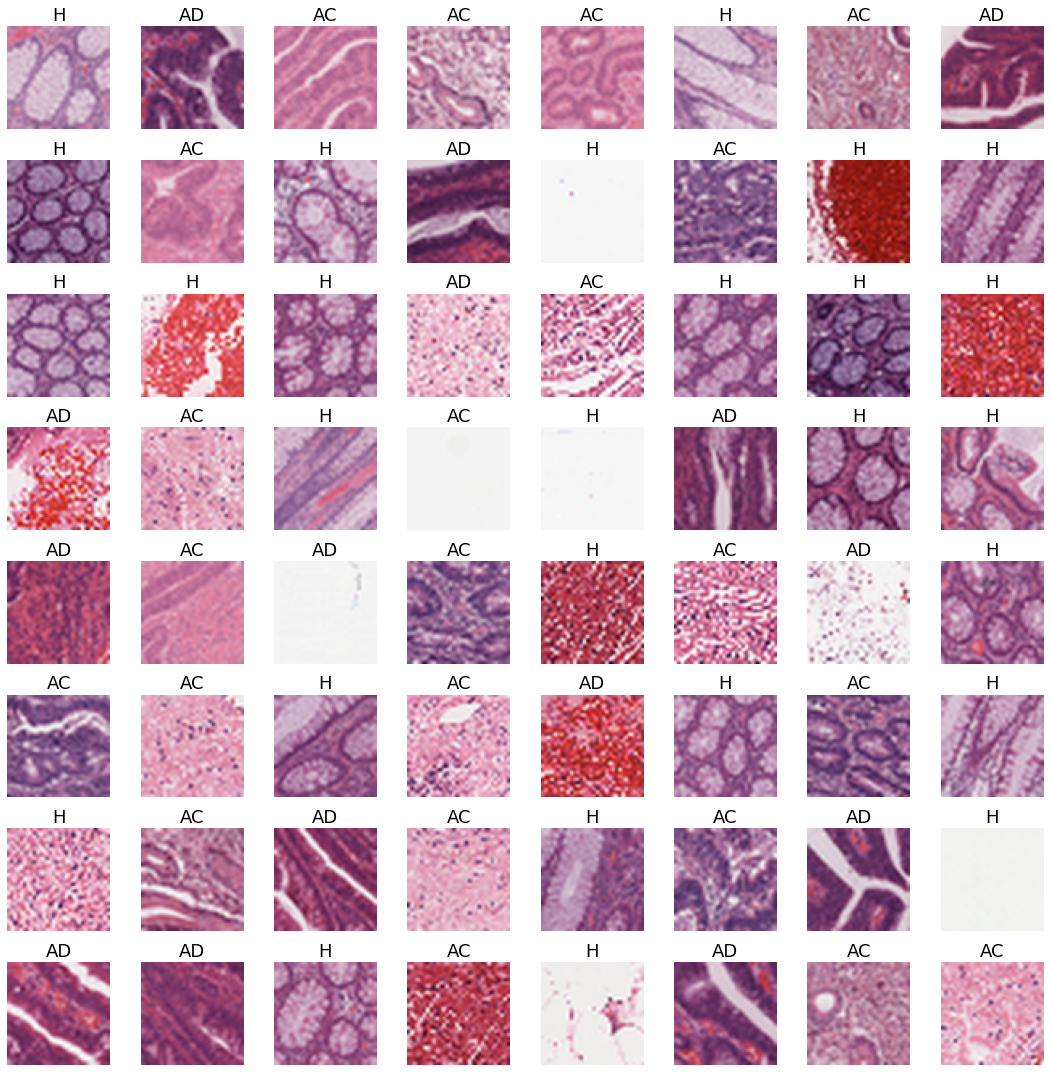

In [7]:
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
ax = ax.ravel()
i = 0
for image, label in test_ds.take(64):
    ax[i].imshow(image.numpy().astype("uint8"))
    ax[i].set_title(class_dict[label.numpy()])
    ax[i].axis("off")
    i += 1
plt.tight_layout()

## Prepare tf dataset pipeline

In [8]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, num_classes, name='label', axis=-1)
train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=len(X_train_noisy))
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
y_true = np.array([y.numpy() for x, y in test_ds])
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# CNN definition and training
You must implement:


1.   An augmentation block
2.   Three callbacks: 

           A) tf.keras.callbacks.ModelCheckpoint
           B) tf.keras.callbacks.EarlyStopping
           C) tf.keras.callbacks.ReduceLROnPlateau


In [9]:
augmentation_block = [
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    tf.keras.layers.RandomRotation(0.3),
]
inputs = tf.keras.Input(input_shape)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
for layer in augmentation_block:
    x = layer(x, training=False)
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet")
for j, layer in enumerate(base_model.layers[:100]):
    layer.trainable = False
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.001,
    patience=15,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
model.fit(train_ds, epochs=epochs, callbacks=[checkpoint_callback, lr_callback, early_stop_callback])
print("Loading {}".format(checkpoint_filepath))
model = tf.keras.models.load_model(checkpoint_filepath)

Epoch 1/100
97/97 [==============================] - 11s 54ms/step - loss: 1.0225 - accuracy: 0.5103


/space/ponzio/teaching-MLinAPP/.venv/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
97/97 [==============================] - 5s 49ms/step - loss: 0.7550 - accuracy: 0.6479
Epoch 3/100
97/97 [==============================] - 5s 48ms/step - loss: 0.6618 - accuracy: 0.6977
Epoch 4/100
97/97 [==============================] - 5s 48ms/step - loss: 0.6123 - accuracy: 0.7246
Epoch 5/100
97/97 [==============================] - 5s 50ms/step - loss: 0.5773 - accuracy: 0.7400
Epoch 6/100
97/97 [==============================] - 5s 50ms/step - loss: 0.5409 - accuracy: 0.7524
Epoch 7/100
97/97 [==============================] - 5s 50ms/step - loss: 0.5202 - accuracy: 0.7576
Epoch 8/100
97/97 [==============================] - 5s 50ms/step - loss: 0.4861 - accuracy: 0.7769
Epoch 9/100
97/97 [==============================] - 5s 50ms/step - loss: 0.4813 - accuracy: 0.7776
Epoch 10/100
97/97 [==============================] - 5s 50ms/step - loss: 0.4624 - accuracy: 0.7863
Epoch 11/100
97/97 [==============================] - 5s 50ms/step - loss: 0.4475 - accuracy: 0.790

## Test the model
Plot a confusion matrix

@@@@@@@@@@@@@@
Accuracy: 0.68
@@@@@@@@@@@@@@


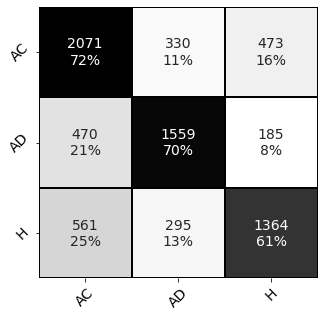

In [11]:
y_pred = model.predict(test_ds, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)
mean_acc = np.mean(np.diag(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]))
print("@" * len("Accuracy: {:.2f}".format(mean_acc)))
print("Accuracy: {:.2f}".format(mean_acc))
print("@" * len("Accuracy: {:.2f}".format(mean_acc)))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
seaborn_cm(cm, ax, sorted(["AC", "AD", "H"]))

# Selective classification applied to histological images

TTA Wrapper

In [12]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(32, 32, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def predict_many_times(self, ds, policy, draws=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(int(self._input_shape[0] - 0.1*self._input_shape[0]),
                                           int(self._input_shape[0] - 0.1*self._input_shape[0])),
                tf.keras.layers.Resizing(self._input_shape[0],
                                         self._input_shape[1])])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal_and_vertical")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.2, 0.2)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(height_factor=(-0.2, .2),
                                           width_factor=(-0.2, .2))])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip
        policies['all'] = sum([policy_random_crop, policy_random_contrast, policy_random_zoom, policy_random_flip], [])

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(draws)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(draws)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(draws)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(draws)], [])
        policies['all'] = sum([policies['all'] for _ in range(draws)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented

In [13]:
tta_model = TTAWrapper(model, input_shape=(64, 64, 3))
many_preds = tta_model.predict_many_times(test_ds, "all", draws=5)

In [14]:
uncertainties = dict()
uncertainties['crc'] = (tta_model.uncertainty_metrics(np.array(many_preds)), 
                        many_preds, y_true)

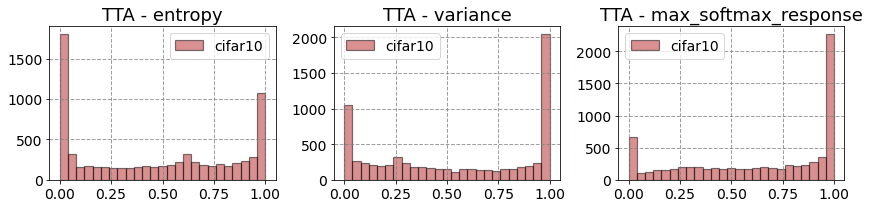

In [15]:
fig, axes = plt.subplots(1, len(tta_model._uncertainty_metrics.keys()), figsize=(12, 3))
for ax, measure in zip(axes, tta_model._uncertainty_metrics.keys()):
    ax.set_title(f"TTA - {measure}")
    ax.hist(uncertainties['crc'][0][measure], 
               color="firebrick", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="cifar10");
    ax.legend()
    plt.tight_layout()

In [16]:
import scipy.stats
def get_risk_bound(n, r_emp, alpha=0.01):
    p_array = np.linspace(0, 1, 100)
    probabilities = np.array(
        [scipy.stats.binom.cdf(r_emp*n, n, p) for p in p_array])
    return p_array[np.where(probabilities < alpha)][0]

In [17]:
def get_theta(y_pred, y_true, r, alpha, confidence_values):
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    thetas = np.array([_ for _ in np.linspace(0, 1, 10)])
    coverages = list()
    risk_bounds = list()
    for theta in thetas:
        try:
            inliers = y_pred[confidence_values > theta]
            inliers_lables = y_true[confidence_values > theta]
            errors = sum(inliers != inliers_lables)
            risk = errors / len(inliers)
            coverages.append(len(inliers) / len(y_pred))
            risk_bounds.append(get_risk_bound(n=len(inliers), 
                                              r_emp=risk, 
                                              alpha=alpha))
        except ZeroDivisionError:
            coverages.append(0)
            risk_bounds.append(0)
    risk_bounds = np.array(risk_bounds)
    indexes = risk_bounds == risk_bounds[risk_bounds <= r][0]
    if sum(indexes) > 1:
        first_true = np.where(indexes == True)[0][0]
        indexes = np.zeros(len(indexes), dtype=bool)
        indexes[first_true] = True
    return float(thetas[indexes]), float(np.array(coverages)[indexes]), float(risk_bounds[indexes])

In [18]:
risk = 0.2
y_true_train = np.array([y.numpy() for x, y in train_ds])
y_pred_train = np.array(tta_model.predict_many_times(train_ds, "all", draws=5)).mean(axis=0)
(theta, coverage, risk_bound) = get_theta(y_pred,
                                          y_true.argmax(axis=1),
                                          risk, 
                                          0.01, 
                                          uncertainties['crc'][0]['variance'])

/space/ponzio/teaching-MLinAPP/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


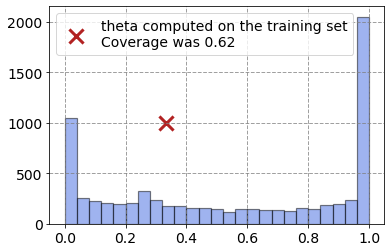

In [19]:
variance = uncertainties['crc'][0]['variance']
fig, ax = plt.subplots(1, 1)
ax.hist(variance,
        color="royalblue", 
        log=False, 
        bins=25, 
        edgecolor='black', 
        linewidth=1.2, 
        alpha=0.5);
ax.scatter(theta, 1000, 
           marker='x', 
           color="firebrick", 
           s=200, 
           linewidth=3,
           label="theta computed on the training set\nCoverage was {:.2f}".format(coverage));
ax.legend();

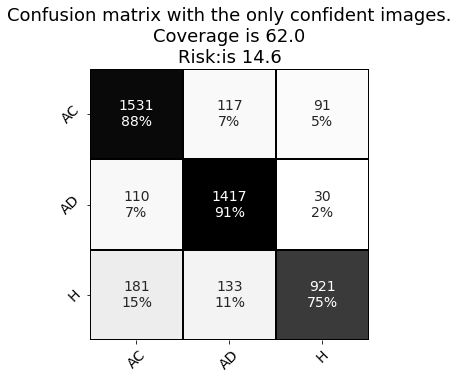

In [21]:
cm = confusion_matrix(y_true[variance>theta].argmax(axis=1), 
                      np.array(many_preds).mean(axis=0).argmax(axis=1)[variance>=theta])
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
seaborn_cm(cm, ax, ["AC", "AD", "H"])
ax.set_title("Confusion matrix with the only confident images.\nCoverage is {:.1f}\nRisk:is {:.1f}".format(
    sum(variance>theta)/len(variance)*100,
    100 - np.sum(np.diag(cm)) / sum(variance>theta) * 100));